In [39]:
#!pip install -r requirements.txt
import subprocess
from tqdm import tqdm
from PIL import Image
import numpy as np
import rasterio as rio

from utils import *
from unet_whole_model import *
from dataset import *

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Observe the full images
We load train & test data, rebuild the full images using the merge_raster.py file and save them.

In [40]:
file_path = "glaciers_mapping_downsampled"
data_paths = {}

#build paths for each pipeline
for pipeline in ["train", "test"]:
    for date in [0,1]:
        data_paths[f"{pipeline}_date{date}"] = f"{file_path}/{pipeline}/date{date}"
    data_paths[f"{pipeline}_gt"] = f"{file_path}/{pipeline}/gt"

In [14]:
#reconstruct full images
for key, path in tqdm(data_paths.items()):
    output_path = f"{file_path}/{key}_merged.tif"
    # Execute the command to merge rasters using subprocess and save them
    command = ["python", "glaciers_mapping_downsampled/merge_rasters.py", "-i", path, "-o", output_path]
    subprocess.run(command)

100%|██████████| 6/6 [01:45<00:00, 17.58s/it]


Then we save the RGB images in png to be able to observe them and (maybe) draw useful conclusions

In [63]:
for key in tqdm(data_paths.keys()):
    img_path = f"{file_path}/{key}_merged"
    img = rio.open(f"{img_path}.tif").read()
    if '_gt' in key:              
        rgb_image = (img).astype(np.uint8).squeeze(0) * 255
        pil_image = Image.fromarray(rgb_image) #blck and white image
    else:
        rgb_image = (img[:3]*255).astype(np.uint8).transpose(1, 2, 0)
        pil_image = Image.fromarray(rgb_image)
    save_path = f"full_rgb_images/{key}.png"
    pil_image.save(save_path)

100%|██████████| 6/6 [00:59<00:00,  9.84s/it]


### Loading all patches

We store the patches in pytorch datasets : 
{
'x' : (position_x_of_patch,
'y' : position_y_of_patch),
'patches' : torch_tensor_of_the_patch
'augmentation' : kind of augmentation performed to get this image, currently none
}

At this stage the tensor of each patch has dimension (band, pixel_x, pixel_y) i.e. (4,128,128) for images and (1,128,128) for groundtruths

In [41]:
all_data = {key : load_data(path) for key, path in data_paths.items()}

Loading data: 100%|██████████| 351/351 [00:00<00:00, 459.31it/s]


In [42]:
train0_dataset = PatchesDataset(all_data['train_date0'], all_data['train_gt'])
train1_dataset = PatchesDataset(all_data['train_date1'], all_data['train_gt'])
test0_dataset = PatchesDataset(all_data['test_date0'], all_data['test_gt'])
test1_dataset = PatchesDataset(all_data['test_date1'], all_data['test_gt'])


### Data Augmentation

In [43]:
train0_dataset.augment()
train1_dataset.augment()

Augmenting dataset: 100%|██████████| 1768/1768 [00:03<00:00, 568.48it/s]


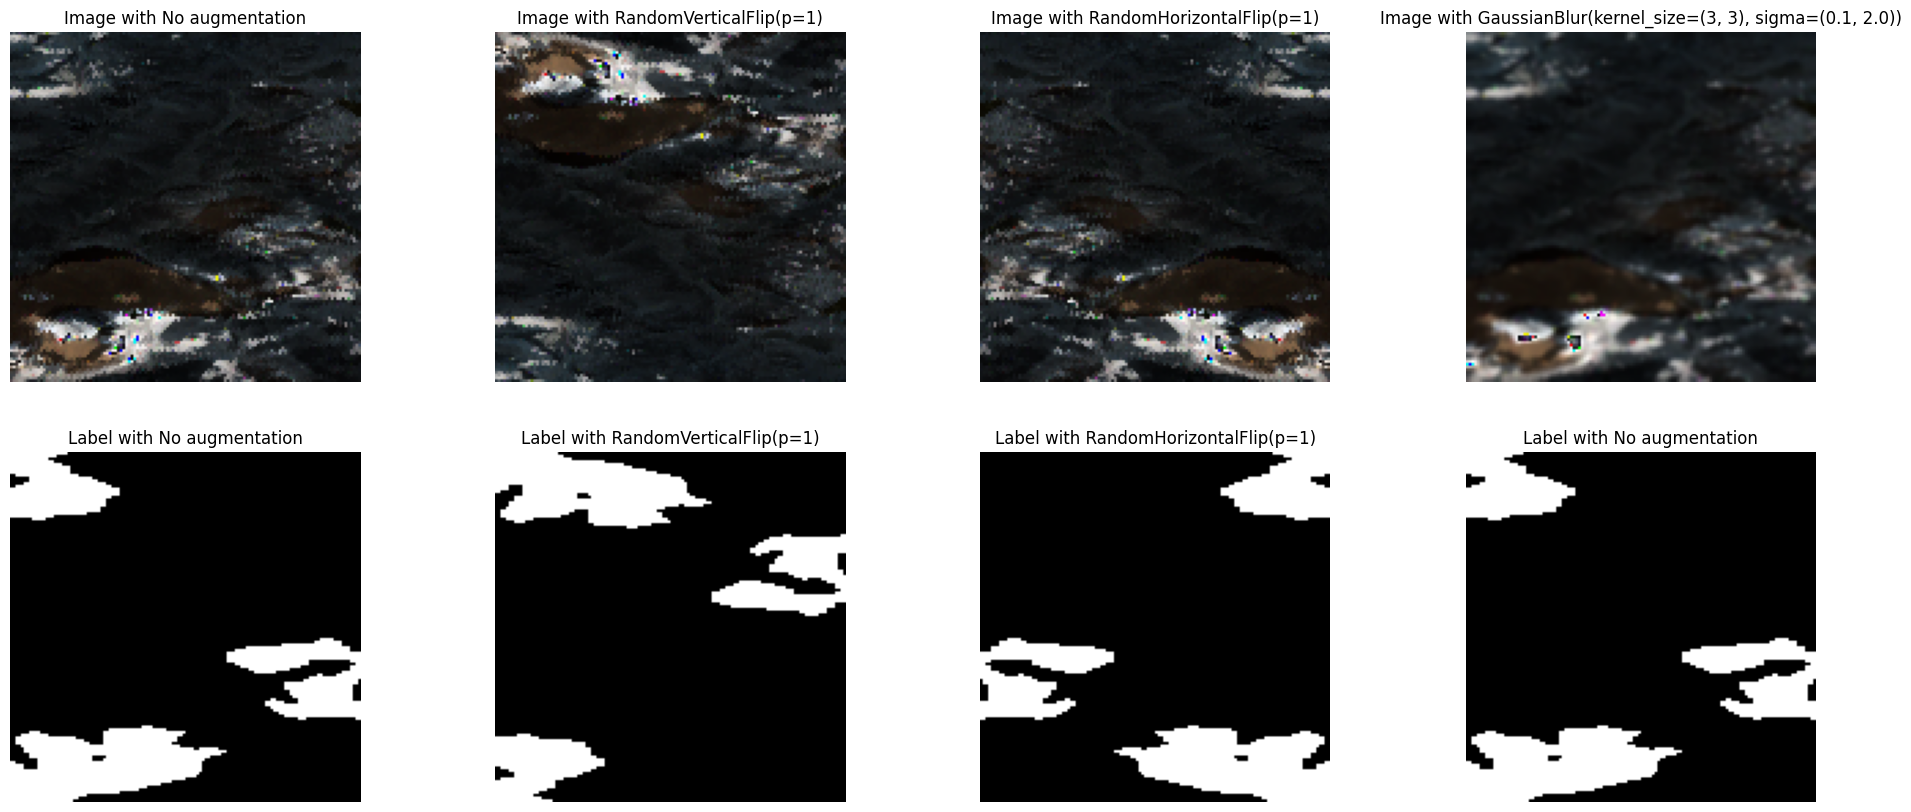

In [44]:
pos_x_ex = 3
pos_y_ex = 8

train0_dataset.plot_at_pos(pos_x_ex, pos_y_ex)

### Preprocessing

In [45]:
train0_dataset.preprocess()
train1_dataset.preprocess()
test0_dataset.preprocess()
test1_dataset.preprocess()

Preprocessing dataset:   2%|▏         | 132/7072 [00:00<00:26, 261.90it/s]

Preprocessing dataset: 100%|██████████| 351/351 [00:00<00:00, 465.65it/s]


### Training

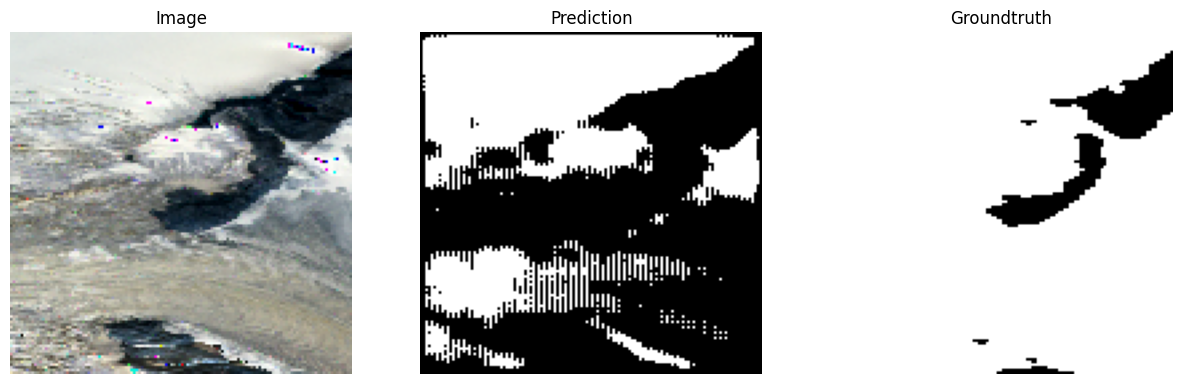

In [38]:
test_model = Model()
test_model.load_model("model_epoch_2")
#test_model.train(train0_dataset, test0_dataset, num_epochs=10)
test_model.plot_prediction(test0_dataset.get_at_pos(2, 3)[0])